# 모듈 및 함수
---

In [1]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from modules.preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from modules.metrics import *
from tsai.all import *
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle


# eval_metrics
def get_clf_eval(y_test, pred = None, pred_proba = None):
    # confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred, average='macro') # 정밀도
    recall = recall_score(y_test, pred, average='macro') # 재현율
    f1 = f1_score(y_test, pred, average='macro') # F1 score
    # roc = roc_auc_score(y_test, pred_proba, multi_class='ovr') # AUC
    
    # print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    # print(f'accuracy : {round(accuracy, 4)} \nprecision : {round(precision, 4)} \nrecall : {round(recall, 4)} \nF1 score : {round(f1, 4)} \nAUC : {round(roc, 4)}')
    print(f'accuracy : {round(accuracy, 4)} \nprecision : {round(precision, 4)} \nrecall : {round(recall, 4)} \nF1 score : {round(f1, 4)}')


# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# # json file 전처리 (미사용)
# def preprocessing_json(json_file):
#     jf = pd.read_json(json_file)
#     jf = jf.T.drop('Path', axis=0).reset_index().drop(['index', 'Vehicle_ID'], axis=1)
    
#     return jf

# # 데이터 전처리
---

## # csv, json 파일 경로를 담은 피클 파일 생성
---
- CSV, JSON 파일을 한 경로에 담기
  - 8월
  -  ㄴ CSV
  -  ㄴ JSON
  - 9월
  -  ㄴ CSV
  -  ㄴ JSON

In [ ]:
data_path_8 = "/data/NIA50/50-1/data/v2xfinal/8월"
data_path_8s = "/data/NIA50/50-1/data/v2xfinal/8월s"
data_path_9 = "/data/NIA50/50-1/data/v2xfinal/9월"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/10월"
data_path_11 = "/data/NIA50/50-1/data/v2xfinal/11월"

data_ls = ['08', '08s', '09', '10', '11']

save_path = '/data/NIA50/50-1/data_last/data_path_pkl/'
os.makedirs(save_path, exist_ok=True)


# csv파일과 json파일 리스트를 pickle로 저장
for i in data_ls:

    # csv파일과 json파일을 각각 리스트로 가져옴
    csv_files = V2XPreprocessing.get_csv_data(globals()[f'data_path_{i}'] + '/CSV')
    json_files = V2XPreprocessing.get_json_data(globals()[f'data_path_{i}'] + '/JSON')
                            
    with open(f"{save_path}/CSV{i}.pkl", "wb") as f:
        pkl.dump(csv_files, f)
    with open(f"{save_path}/JSON{i}.pkl", "wb") as f:
        pkl.dump(json_files, f)

    print(f"csv{i} file count: {len(csv_files)}, json{i} file count: {len(json_files)}")

## # csv, json 데이터프레임 생성
---

In [ ]:
load_path = '/data/NIA50/docker/50-1/data/data_path_pkl'
save_path = '/data/NIA50/docker/50-1/data/raw/8to11'
save_path8s = '/data/NIA50/docker/50-1/data/raw/8s'

# csv, json 파일 리스트를 pickle로 가져와서 데이터프레임으로 저장
data_ls = ['08', '08s', '09', '10', '11']

for i in data_ls[:1]:
    print(f'{i}월')
    
    # csv 불러오기
    with open(f"{load_path}/CSV{i}.pkl", "rb") as f:
        csv_files = pkl.load(f)
    df_csv_ls = [pd.read_csv(cf) for cf in tqdm(csv_files, desc="Reading csv files")]
    df_csv = pd.concat(df_csv_ls, ignore_index=True)
    
    # json 불러오기
    with open(f"{load_path}/JSON{i}.pkl", "rb") as f:
        json_files = pkl.load(f)

    json_ls = []
    cols = ['Hazard', 'Lane', 'Speed', 'Turn']
    for jf in tqdm(json_files[:10], desc="Reading json files"):
        with open(jf, 'r') as f:
            temp_js = json.load(f)
            temp_js = [temp_js['Annotation'][key] for key in temp_js['Annotation'].keys() if key in cols]
            json_ls.append(temp_js)

    df_js = pd.DataFrame(data=np.asarray(json_ls), columns=cols)


    # csv, json raw data 저장
    if i=='08s':
        with open(f"{save_path8s}/df{i}csv.pkl", "wb") as f:
            pkl.dump(df_csv, f)
        with open(f"{save_path8s}/df{i}js.pkl", "wb") as f:
            pkl.dump(df_js, f)

    else:
        with open(f"{save_path}/df{i}csv.pkl", "wb") as f:
            pkl.dump(df_csv, f)
        with open(f"{save_path}/df{i}js.pkl", "wb") as f:
            pkl.dump(df_js, f)

## # 변수, 라벨링 전처리 및 저장
---

### # 8, 9, 10, 11월 데이터
---

In [3]:
src = '/data/NIA50/docker/50-1/data/8to11/raw'
dst = '/data/NIA50/docker/50-1/data/8to11/scaled'

# 8, 9, 10, 11월 csv 합치기
csv_ls = sorted(glob.glob(f'{src}/*csv.pkl'))
df8to11_csv_ls = [pd.read_pickle(f) for f in csv_ls]
df8to11_csv = pd.concat(df8to11_csv_ls, ignore_index=True).drop('ISSUE_DATE', axis=1).dropna().reset_index(drop=True)
df8to11_csv = df8to11_csv.iloc[:-1]


# csv 데이터를 변수로 만들기
# df8to11 = pd.read_pickle('/data/NIA50/docker/50-1/data/8to11/raw/df8to11csv.pkl')
for col in ['VEHICLE_ID', 'VEHICLE_CLASS', 'VEHICLE_TYPE']:
    df8to11_csv[col] = df8to11_csv[col].astype(str)

    encoder = LabelEncoder()
    df8to11_csv[col] = encoder.fit_transform(df8to11_csv[col])

# for col in ['LONGITUDE', 'LATITUDE', 'HEADING', 'SPEED', 'BRAKE_STATUS', 'ACC_SEC']:
for col in df8to11_csv.columns:
    df8to11_csv[col] = df8to11_csv[col].astype(float)

    scaler = StandardScaler()
    df8to11_csv[col] = scaler.fit_transform(df8to11_csv[[col]])

# one-hot encoding (사용 안함)
# idx_range = 10000
# df8to11_OH_ls = []
# for i in tqdm(np.arange(len(df8to11)/idx_range)):
#     min_idx = int(i*idx_range)
#     max_idx = int((i+1)*idx_range)
#     df8to11_OH = pd.get_dummies(df8to11[min_idx:max_idx])
#     df8to11_OH_ls.append(df8to11_OH)

# df8to11_processed = pd.concat(df8to11_OH_ls, ignore_index=True).fillna(0.0)
# df8to11_processed.to_pickle('/data/NIA50/docker/50-1/data/8to11/raw/df8to11_processed.pkl')


# X, y 데이터 만들기
X_8to11 = df8to11_csv.values.reshape(df8to11_csv.shape[0]//10, 10, -1)
X_8to11 = X_8to11.transpose(0, 2, 1)
np.save(f'{dst}/X_8to11.npy', X_8to11)

js_ls = sorted(glob.glob(f'{src}/*js.pkl'))
df8to11_js_ls = [pd.read_pickle(f) for f in js_ls]
df8to11_js = pd.concat(df8to11_js_ls, ignore_index=True).dropna().reset_index(drop=True)
np.save(f'{dst}/y_8to11.npy', df8to11_js.values)

### # 8월(세종) 데이터
---

In [8]:
src = '/data/NIA50/docker/50-1/data/8s/raw'
dst = '/data/NIA50/docker/50-1/data/8s/scaled'

# 8s sv 합치기
csv_ls = sorted(glob.glob(f'{src}/*csv.pkl'))
df8s_csv_ls = [pd.read_pickle(f) for f in csv_ls]
df8s_csv = pd.concat(df8s_csv_ls, ignore_index=True).drop('ISSUE_DATE', axis=1).dropna().reset_index(drop=True)


# csv 데이터를 변수로 만들기
# df8to11 = pd.read_pickle('/data/NIA50/docker/50-1/data/8to11/raw/df8to11csv.pkl')
for col in ['VEHICLE_CLASS']:
    df8s_csv[col] = df8s_csv[col].astype(str)

    encoder = LabelEncoder()
    df8s_csv[col] = encoder.fit_transform(df8s_csv[col])

# for col in ['LONGITUDE', 'LATITUDE', 'HEADING', 'SPEED', 'BRAKE_STATUS', 'ACC_SEC']:
for col in df8s_csv.columns:
    df8s_csv[col] = df8s_csv[col].astype(float)

    scaler = StandardScaler()
    df8s_csv[col] = scaler.fit_transform(df8s_csv[[col]])


# X, y 데이터 만들기
X_8s = df8s_csv.values.reshape(df8s_csv.shape[0]//10, 10, -1)
X_8s = X_8s.transpose(0, 2, 1)
np.save(f'{dst}/X_8s.npy', X_8s)

js_ls = sorted(glob.glob(f'{src}/*js.pkl'))
df8s_js_ls = [pd.read_pickle(f) for f in js_ls]
df8s_js = pd.concat(df8s_js_ls, ignore_index=True).dropna().reset_index(drop=True)
np.save(f'{dst}/y_8s.npy', df8s_js.values)


# # 훈련
---

## # 8, 9, 10, 11월
---

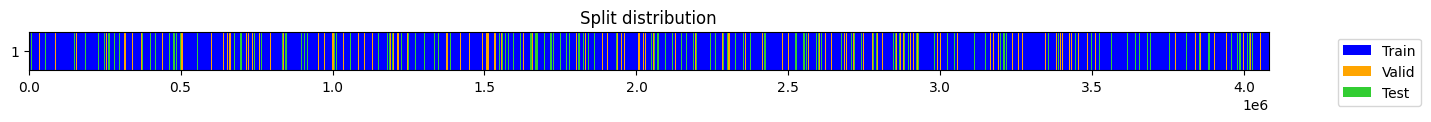

In [14]:
# 데이터 준비

src = '/data/NIA50/docker/50-1/data/8to11/scaled'
dst_t = 'pth/8to11/turn/'
dst_s = 'pth/8to11/speed/'
dst_h = 'pth/8to11/hazard/'
dst_test = '/data/NIA50/docker/50-1/data/8to11/test'

X_8to11 = np.load(f'{src}/X_8to11.npy')
y_8to11 = np.load(f'{src}/y_8to11.npy', allow_pickle=True)

# y_8to11_turn = y_8to11[:, 0]
# y_8to11_speed = y_8to11[:, 2]
y_8to11_hazard = y_8to11[:, 3]


# 데이터 분할
# split_t = get_splits(y_8to11_turn, shuffle=True, valid_size=0.1, test_size=0.1, random_state=44)
# split_s = get_splits(y_8to11_speed, shuffle=True, valid_size=0.1, test_size=0.1, random_state=44)
split_h = get_splits(y_8to11_hazard, shuffle=True, valid_size=0.1, test_size=0.1, random_state=44)


# # 테스트 데이터 생성
# for cat, split in zip(['turn', 'speed', 'hazard'], [split_t, split_s, split_h]):
#     split_test = (split[0], split[2], split[1])
#     tfms = [None, [Categorize]]
#     dsets = TSDatasets(X_8to11, globals()[f'y_8to11_{cat}'], tfms=tfms, splits=split_test, inplace=False)
#     dls_test = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], shuffle_train=False, batch_tfms=[TSStandardize()]).valid
#     torch.save(dls_test, f'{dst_test}/dls8to11_test_{cat}.pkl', pickle_protocol=4)


# 모델 설정
config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 10,)

# RunTSAI.target_label_counter(y_8to11)

### # Turn
---

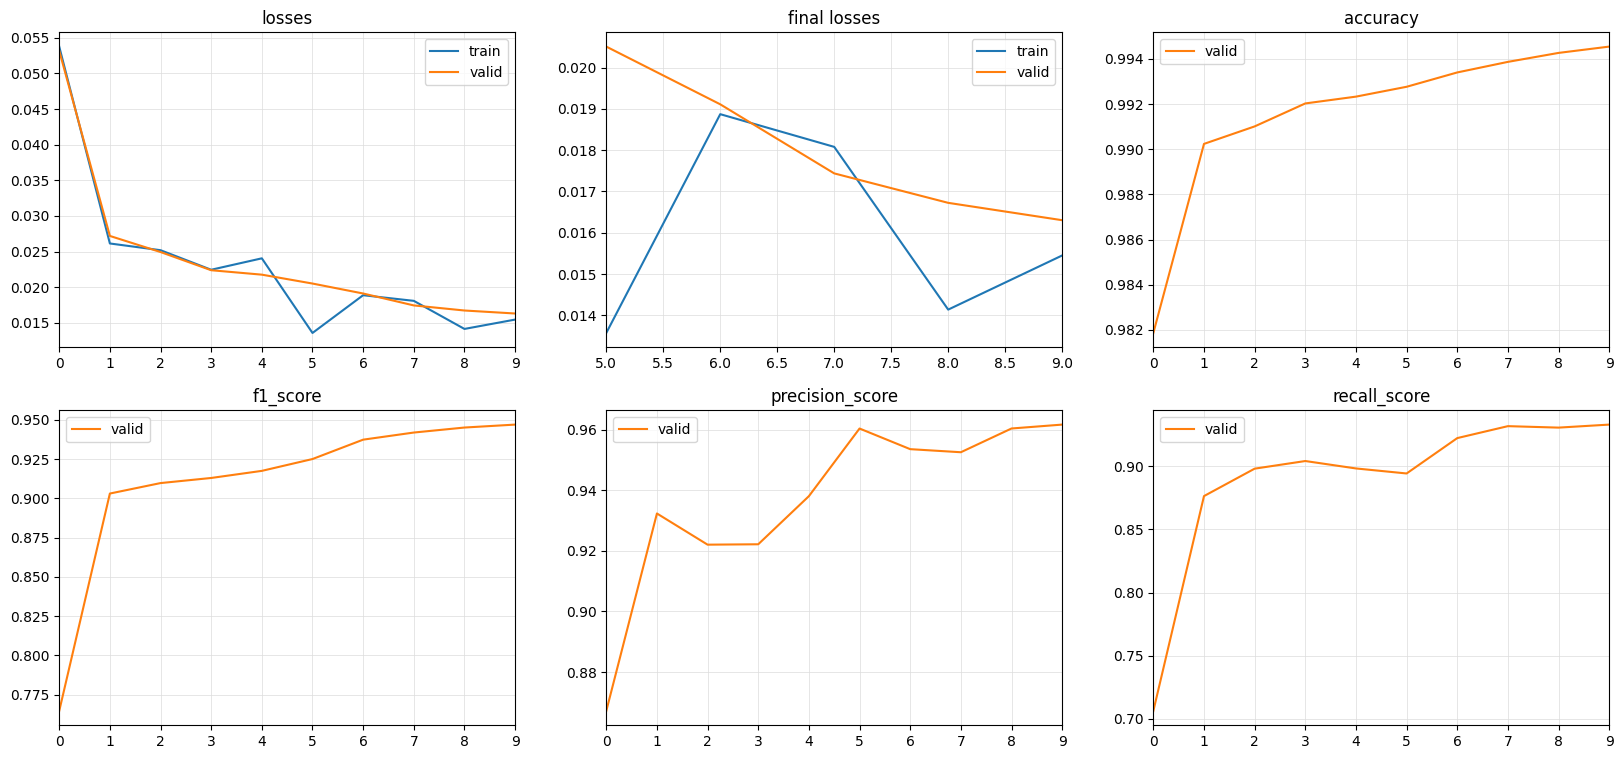

In [3]:
# 훈련
learn8to10_hazard = RunTSAI.multiclass_classification(X_8to11, 
                                                      y_8to11_turn,
                                                      split=split_t,
                                                      config=config, 
                                                      save_path=dst_t)

### # Speed
---

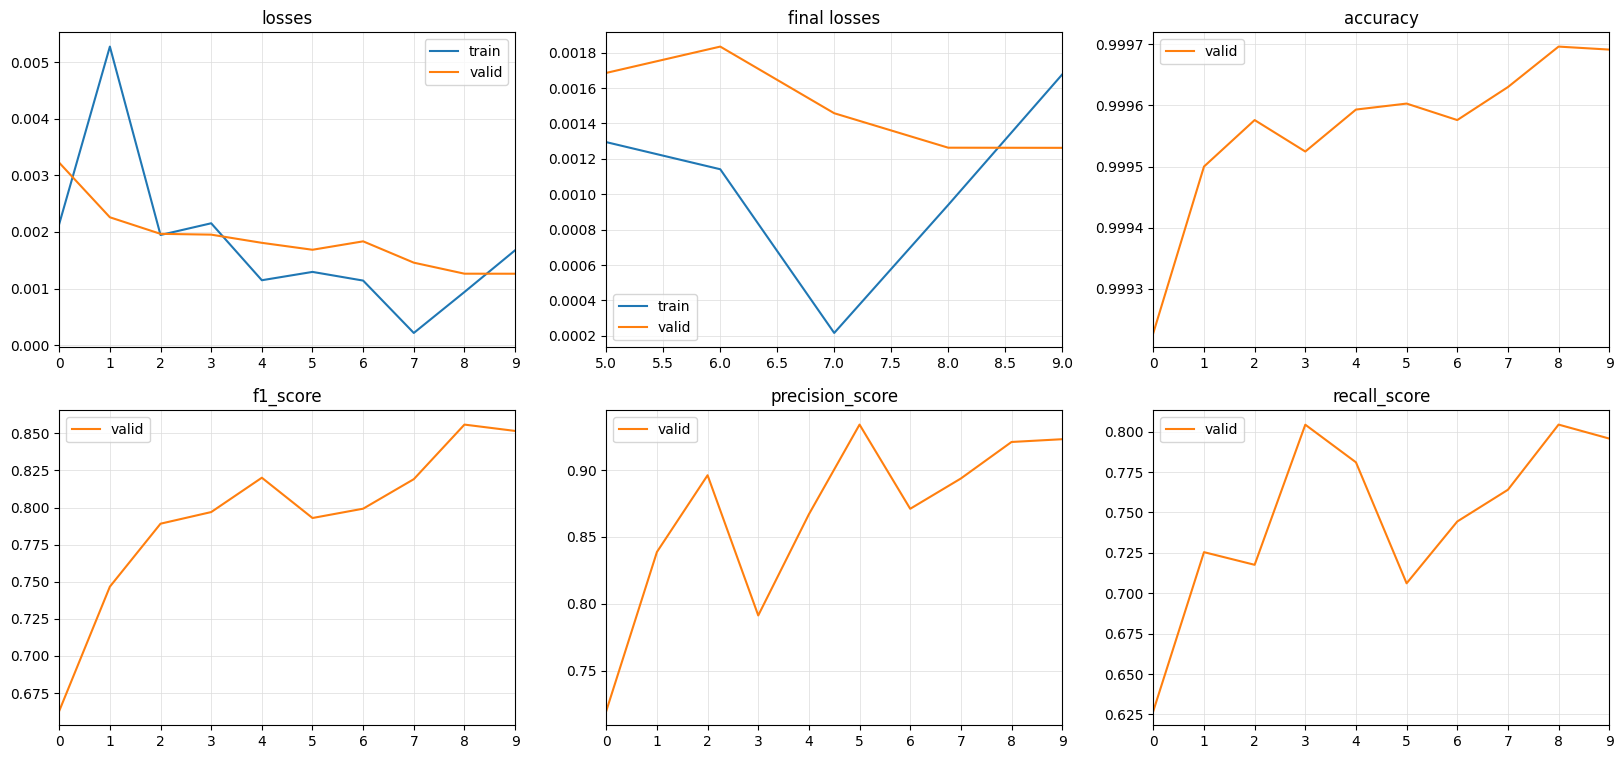

In [3]:
# 훈련
learn8to10_speed = RunTSAI.multiclass_classification(X_8to11, 
                                                     y_8to11_speed, 
                                                     split=split_s, 
                                                     config=config, 
                                                     save_path=dst_s)

### # Hazard
---

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.023311,0.022148,0.996669,0.499166,0.498335,0.500000,00:30
1,0.022202,0.022077,0.996669,0.499166,0.498335,0.500000,00:30
2,0.022782,0.022078,0.996669,0.499166,0.498335,0.500000,00:30
3,0.022507,0.022000,0.996669,0.499166,0.498335,0.500000,00:31
4,0.019838,0.022105,0.996669,0.499166,0.498335,0.500000,00:32
5,0.020098,0.022032,0.996669,0.499166,0.498335,0.500000,00:31
6,0.023542,0.022091,0.996669,0.499166,0.498335,0.500000,00:30
7,0.022960,0.022000,0.996669,0.499166,0.498335,0.500000,00:31
8,0.022836,0.021944,0.996669,0.499166,0.498335,0.500000,00:31
9,0.021640,0.022063,0.996669,0.499166,0.498335,0.500000,00:30


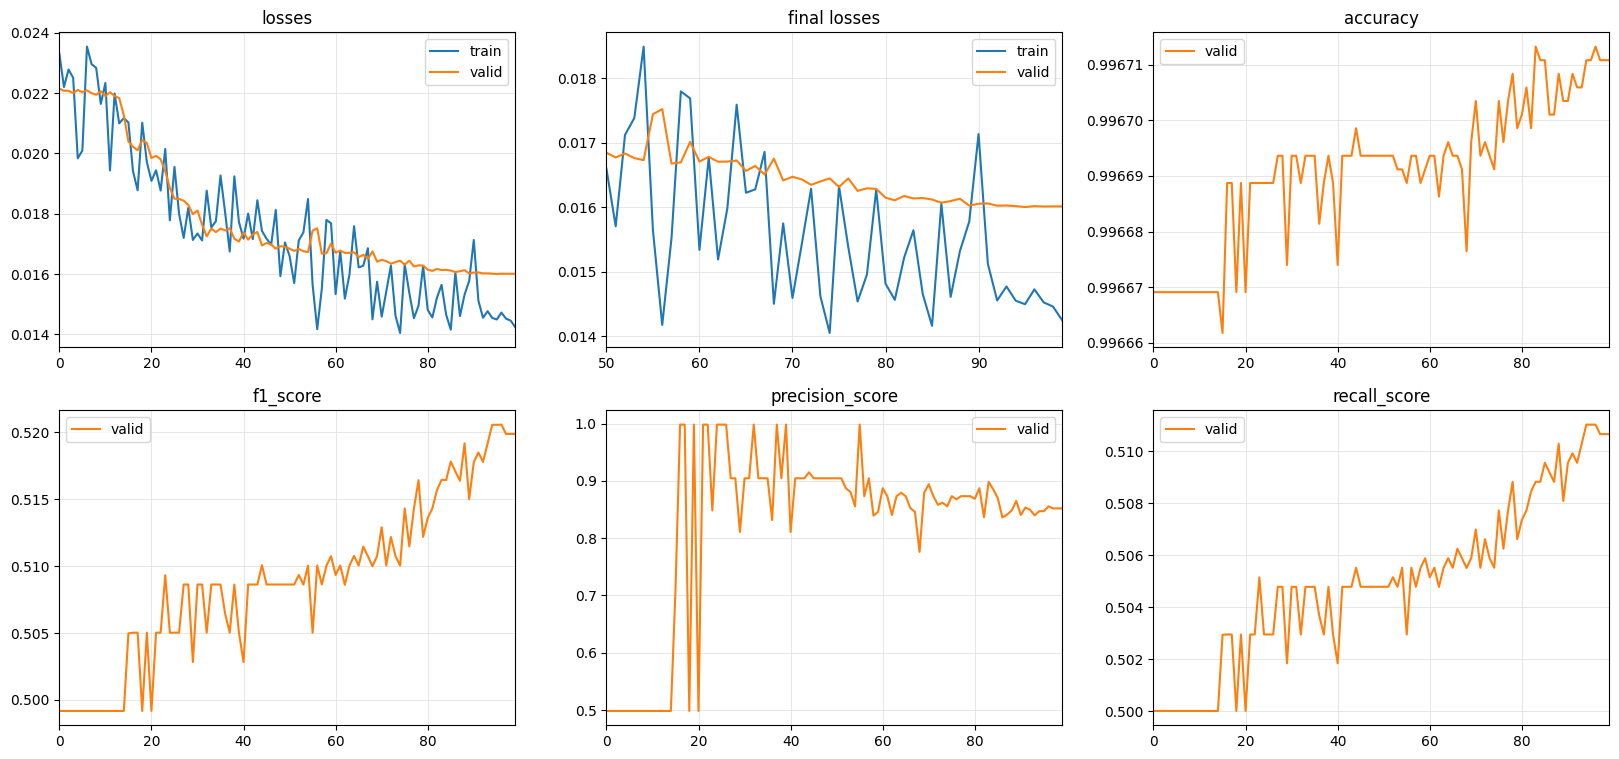

In [15]:
config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 100,)

# 훈련
learn8to11_turn = RunTSAI.multiclass_classification(X_8to11, 
                                                    y_8to11_hazard, 
                                                    split=split_h,
                                                    config=config, 
                                                    save_path='/data/NIA50/docker/50-1/models/pth/8to11/hazard2')

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.021215,0.022108,0.996669,0.499166,0.498335,0.500000,00:34
1,0.023287,0.022017,0.996669,0.499166,0.498335,0.500000,00:31
2,0.022274,0.022029,0.996669,0.499166,0.498335,0.500000,00:30
3,0.020466,0.022030,0.996669,0.499166,0.498335,0.500000,00:31
4,0.022937,0.021928,0.996669,0.499166,0.498335,0.500000,00:30
5,0.021271,0.021894,0.996684,0.505013,0.898344,0.502941,00:31
6,0.020520,0.020857,0.996689,0.505023,0.998344,0.502943,00:30
7,0.019526,0.020457,0.996689,0.505023,0.998344,0.502943,00:30
8,0.021845,0.020068,0.996689,0.505023,0.998344,0.502943,00:30
9,0.019273,0.019996,0.996689,0.505023,0.998344,0.502943,00:31


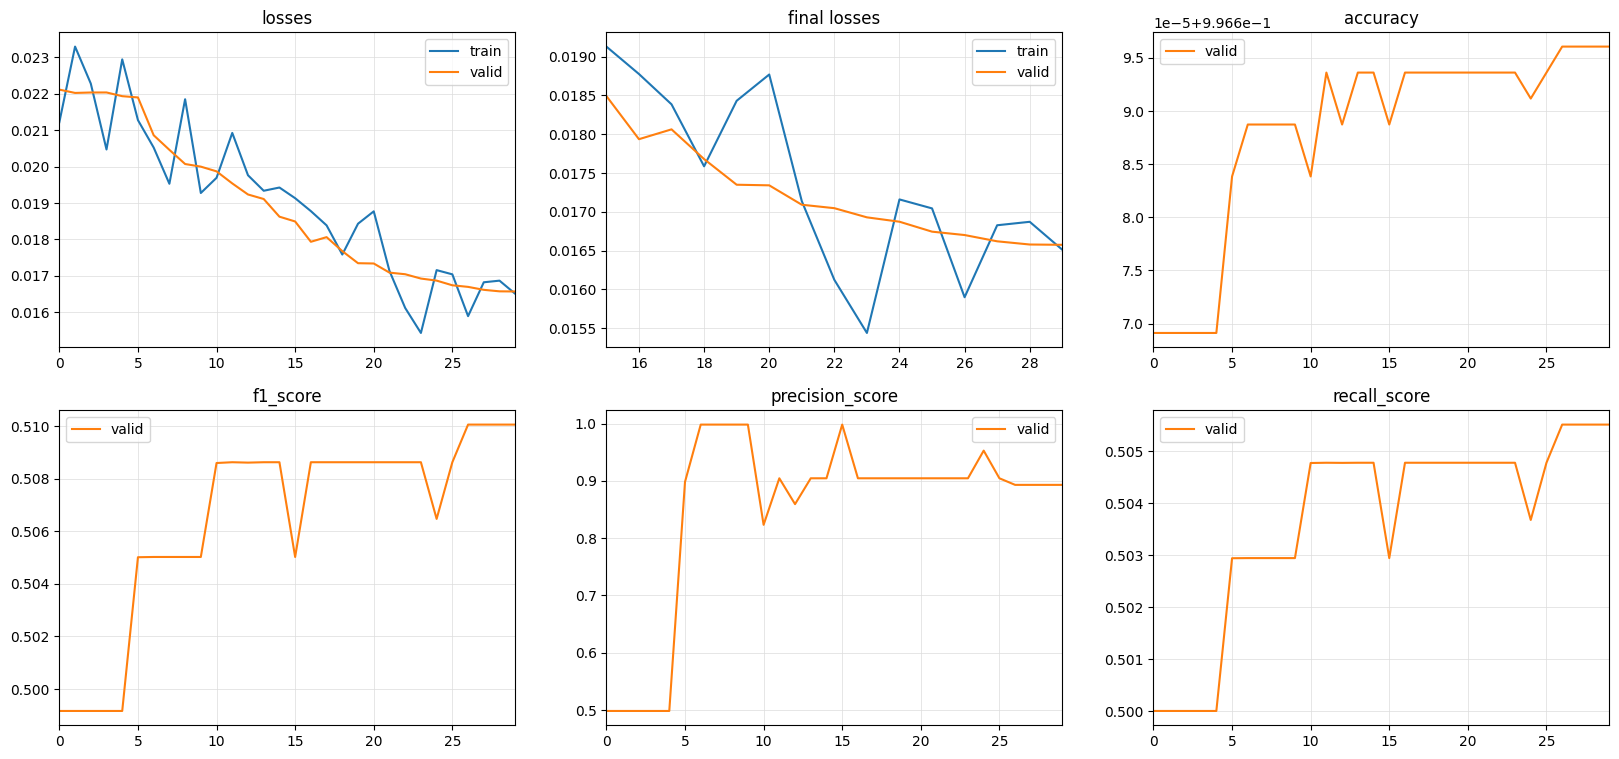

In [6]:
config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 30,)

# 훈련
learn8to10_turn = RunTSAI.multiclass_classification(X_8to11, 
                                                    y_8to11_hazard, 
                                                    split=split_h,
                                                    config=config, 
                                                    save_path=dst_h)

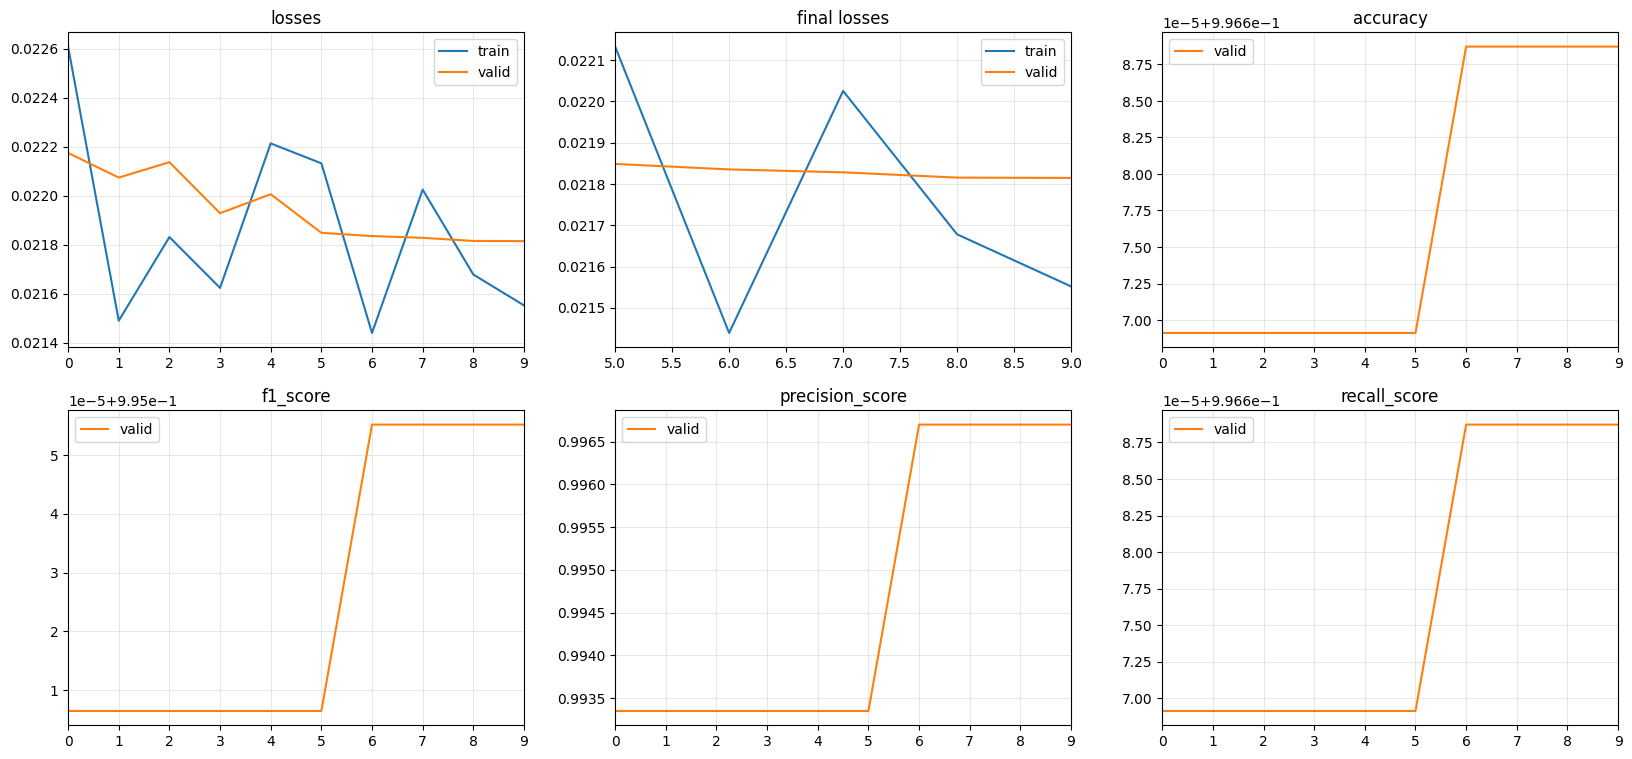

In [3]:
# 훈련
learn8to10_turn = RunTSAI.multiclass_classification(X_8to11, 
                                                    y_8to11_hazard, 
                                                    split=split_h,
                                                    config=config, 
                                                    save_path=dst_h)

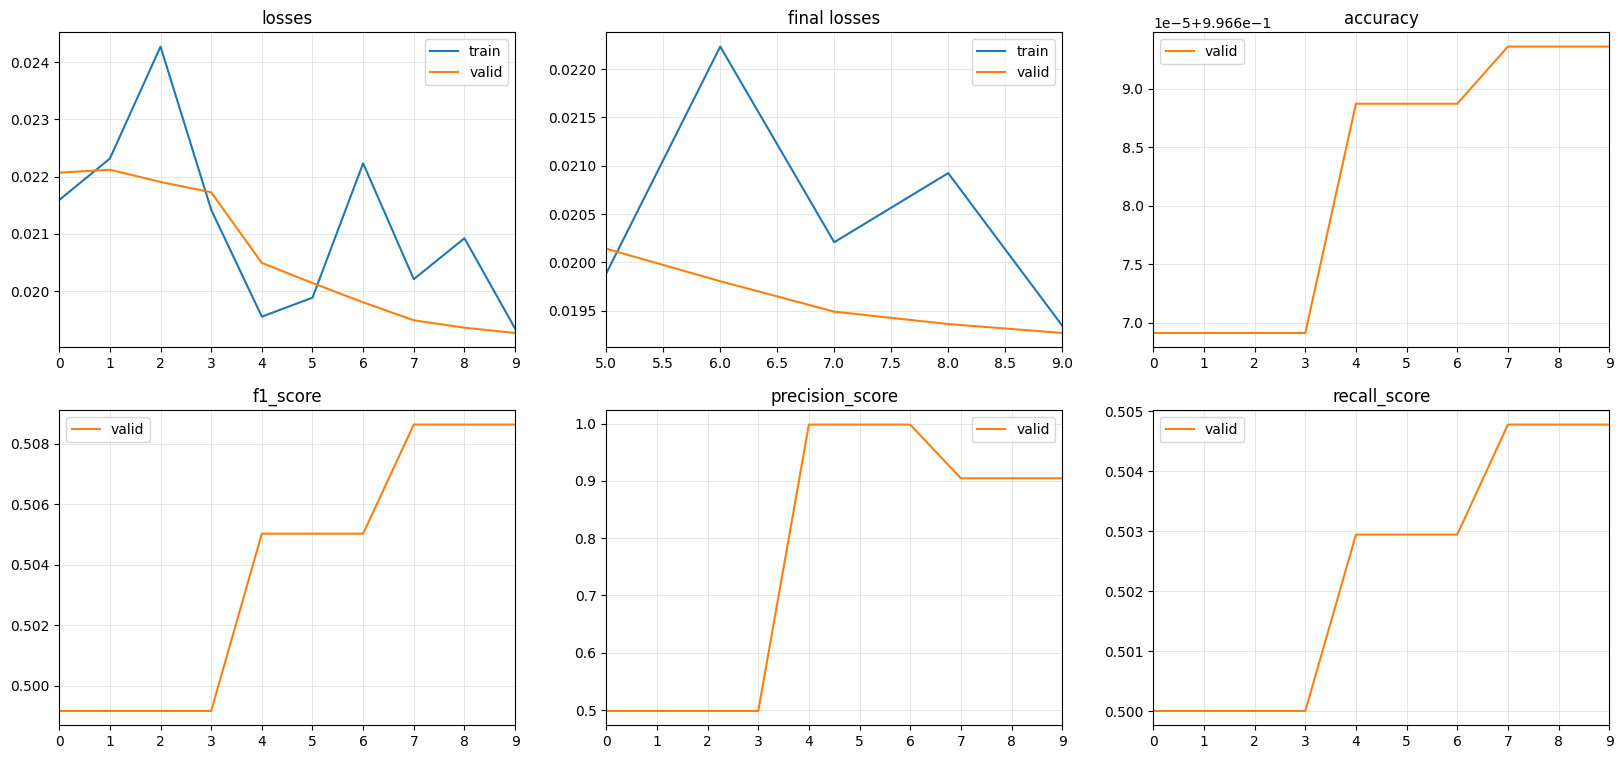

In [3]:
# 훈련
learn8to10_turn = RunTSAI.multiclass_classification(X_8to11, 
                                                    y_8to11_hazard, 
                                                    split=split_h, 
                                                    config=config, 
                                                    save_path=dst_h)

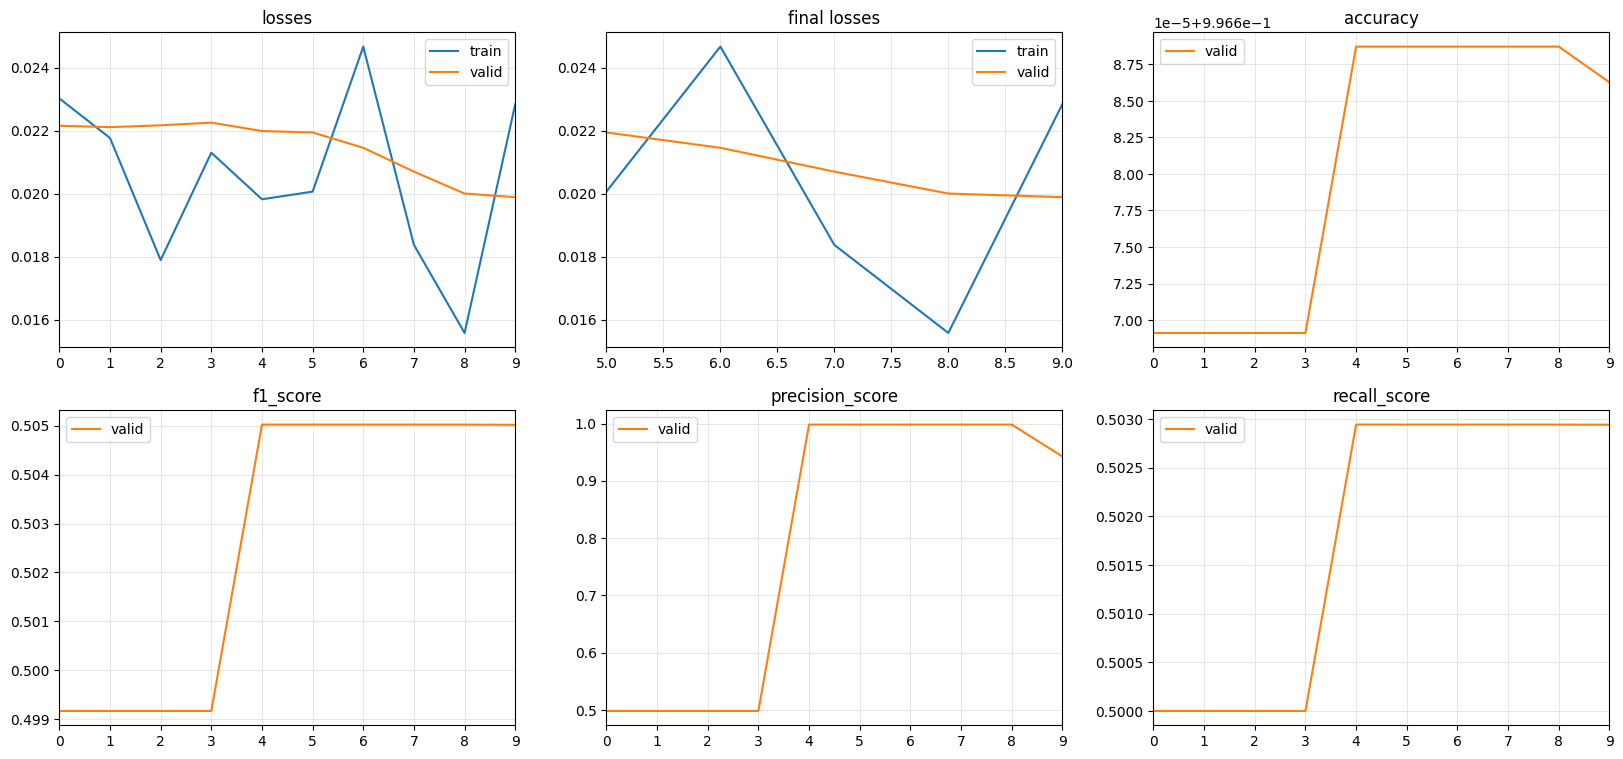

In [4]:
# 훈련
learn8to10_turn = RunTSAI.multiclass_classification(X_8to11, 
                                                    y_8to11_hazard, 
                                                    split=split_h, 
                                                    config=config, 
                                                    save_path=dst_h)

## # 8월(세종)
---

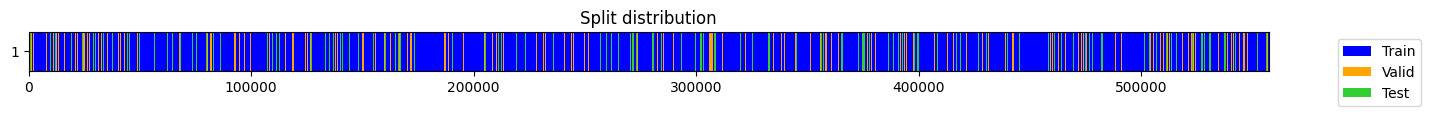

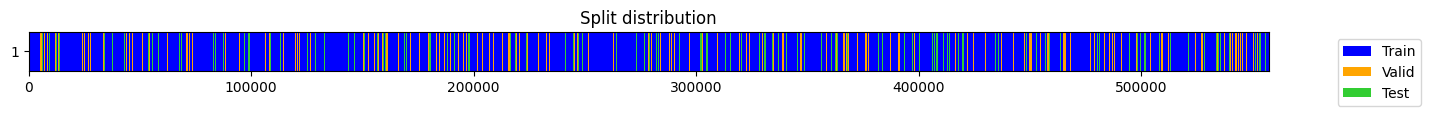

[Counter({'False': 530427, 'Left': 6601, 'Right': 8288, 'Reverse': 11902}),
 Counter({'False': 557218}),
 Counter({'False': 507399, 'Hbrk': 25337, 'Acc': 24482}),
 Counter({'False': 557218})]

In [2]:
# 데이터 준비

src = '/data/NIA50/docker/50-1/data/8s/scaled'
dst_t = 'pth/8s/turn/'
dst_s = 'pth/8s/speed/'
dst_test = '/data/NIA50/docker/50-1/data/8s/test'
os.makedirs(dst_test, exist_ok=True)

X_8s = np.load(f'{src}/X_8s.npy')
y_8s = np.load(f'{src}/y_8s.npy', allow_pickle=True)

y_8s_turn = y_8s[:, 0]
y_8s_speed = y_8s[:, 2]
# y_8s_turn = y_8s[:, 3]


# 데이터 분할
split_t = get_splits(y_8s_turn, shuffle=True, valid_size=0.1, test_size=0.1, random_state=44)
split_s = get_splits(y_8s_speed, shuffle=True, valid_size=0.1, test_size=0.1, random_state=44)
# split_t = get_splits(y_8s_turn, shuffle=True, valid_size=0.1, test_size=0.1, random_state=44)


# 테스트 데이터 생성
# for cat, split in zip(['turn', 'speed'], [split_t, split_s]):
#     split_test = (split[0], split[2], split[1])
#     tfms = [None, [Categorize]]
#     dsets = TSDatasets(X_8s, globals()[f'y_8s_{cat}'], tfms=tfms, splits=split_test, inplace=False)
#     dls_test = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], shuffle_train=False, batch_tfms=[TSStandardize()]).valid
#     torch.save(dls_test, f'{dst_test}/dls8s_test_{cat}.pkl', pickle_protocol=4)


# 모델 설정
config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 10,)

RunTSAI.target_label_counter(y_8s)

### # Turn
---

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.368586,0.259971,0.947524,0.252981,0.275134,0.254808,00:04
1,0.207287,0.204268,0.951921,0.243842,0.237980,0.250000,00:04
2,0.178983,0.179128,0.951921,0.243842,0.237980,0.250000,00:04
3,0.171864,0.171991,0.951921,0.243842,0.237980,0.250000,00:04
4,0.165949,0.159651,0.952101,0.249441,0.398818,0.252808,00:03
5,0.146886,0.145066,0.951473,0.311850,0.441860,0.290943,00:03
6,0.139364,0.136367,0.951706,0.345090,0.452519,0.317981,00:03
7,0.129463,0.130495,0.953034,0.368498,0.494843,0.332737,00:03
8,0.126916,0.124392,0.955834,0.485261,0.672214,0.425683,00:04
9,0.120369,0.116978,0.958813,0.515894,0.729689,0.440165,00:04


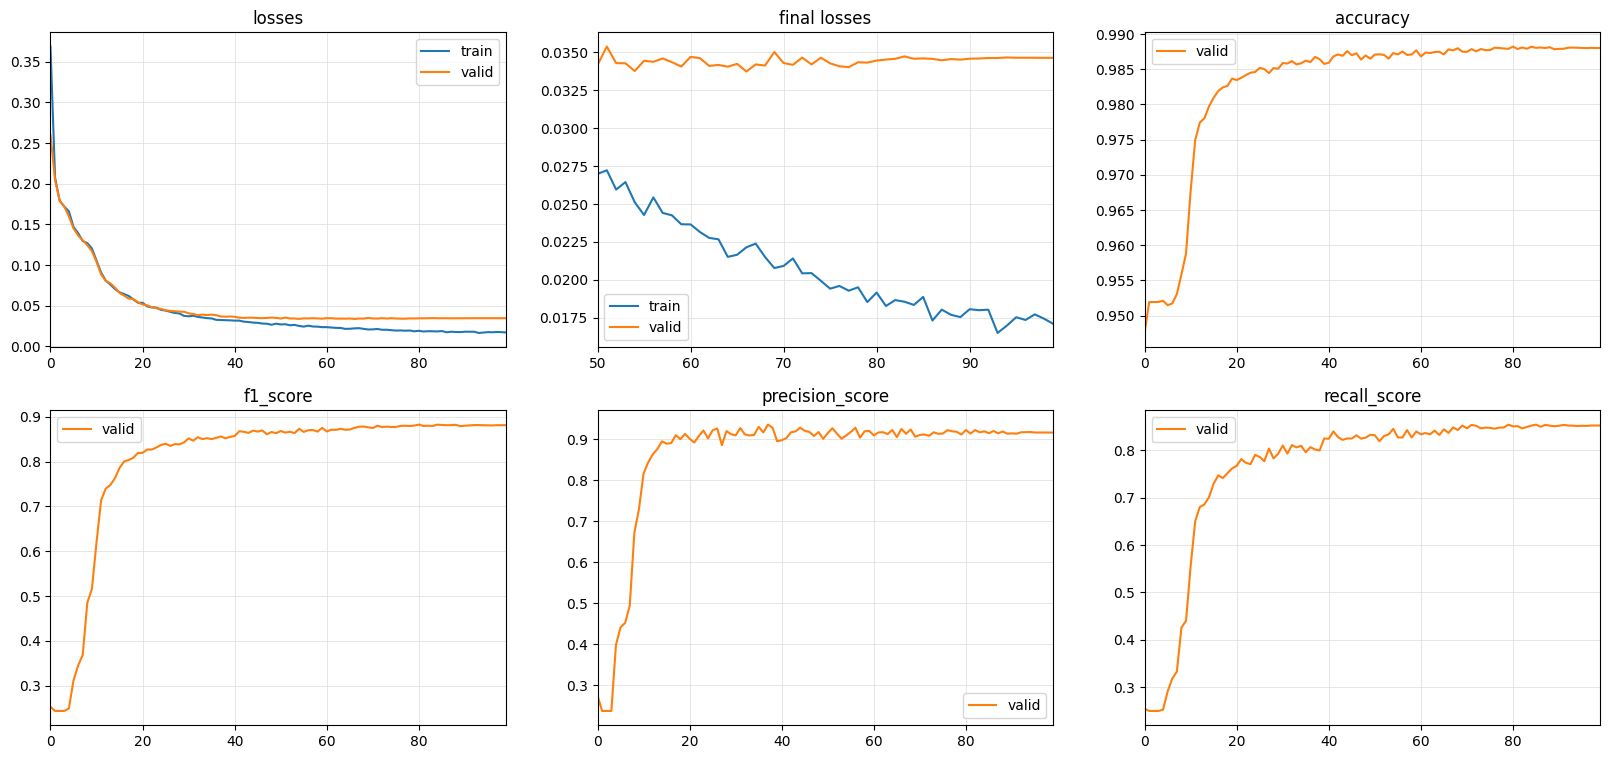

In [12]:
config = AttrDict(
    batch_tfms = TSStandardize(),
    architecture = LSTM, # LSTM, LSTM_FCNPlus, MLSTM_Plus
    n_epochs = 100,)

# 훈련
learn8s_hazard = RunTSAI.multiclass_classification(X_8s, 
                                                   y_8s_turn, 
                                                   split=split_t,
                                                   config=config, 
                                                   save_path='/data/NIA50/docker/50-1/models/pth/8s/turn2')

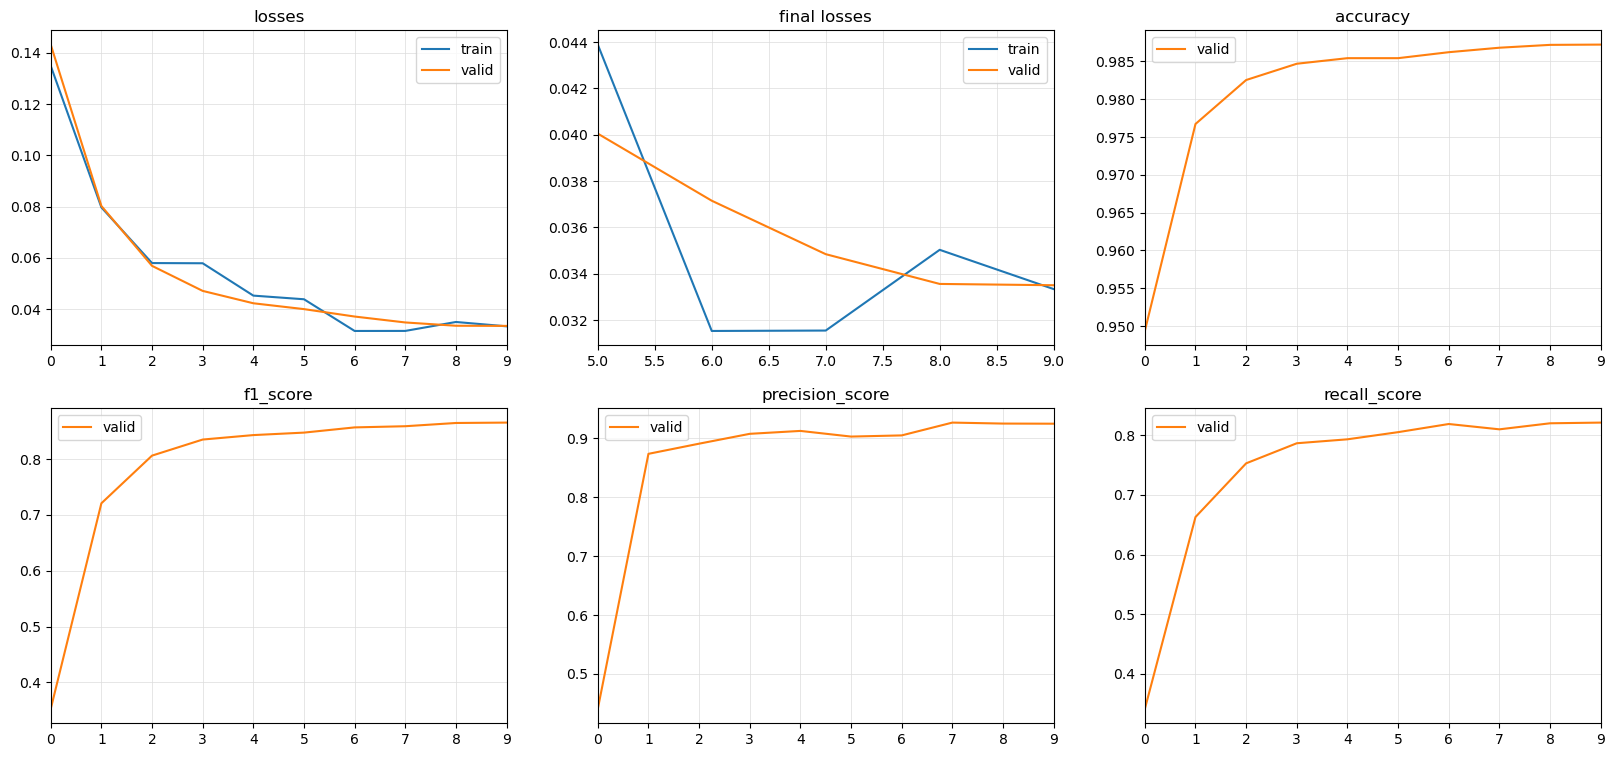

In [4]:
# 훈련
learn8s_hazard = RunTSAI.multiclass_classification(X_8s, 
                                                   y_8s_turn, 
                                                   split=split_t,
                                                   config=config, 
                                                   save_path=dst_t)

### # Speed
---

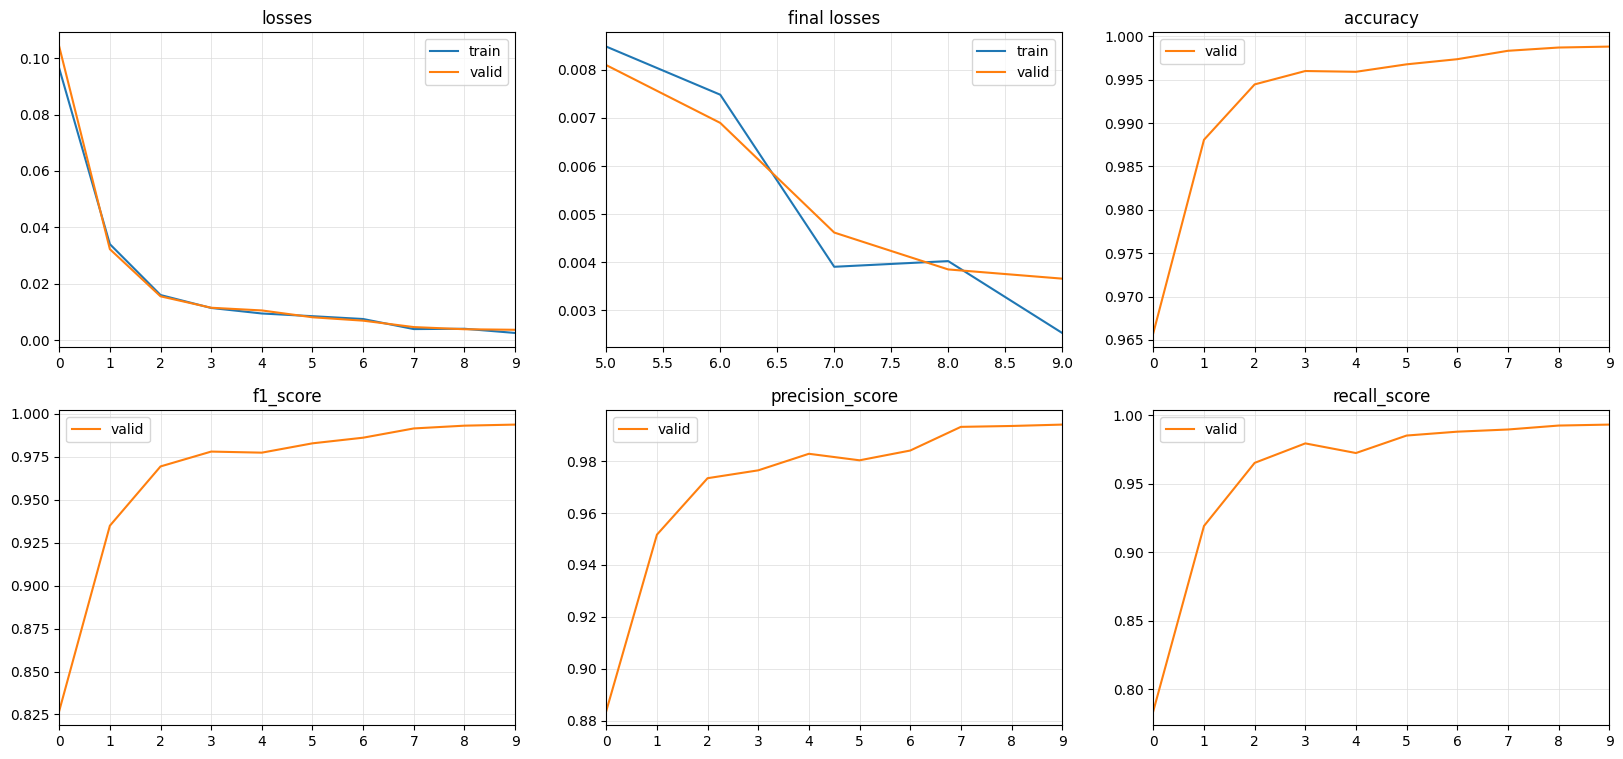

In [4]:
# 훈련
learn8s_speed = RunTSAI.multiclass_classification(X_8s, 
                                                 y_8s_speed, 
                                                 split=split_s, 
                                                 config=config, 
                                                 save_path=dst_s)

# # 테스트
---

## # 8, 9, 10 ,11월
---

### # Turn
---

accuracy : 0.9923 
precision : 0.9922 
recall : 0.9923 
F1 score : 0.9922


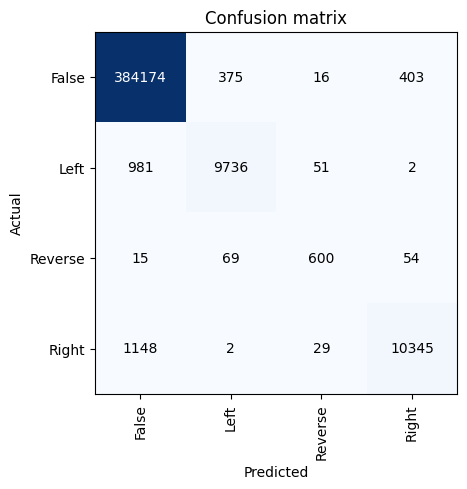

In [5]:
model_src = '/data/NIA50/docker/50-1/models/pth/8to11/turn'
test_src = '/data/NIA50/docker/50-1/data/8to11/test/dls8to11_test_turn.pkl'

learn = load_learner_all(dls_fname=f'{model_src}/dls', model_fname=f'{model_src}/model', learner_fname=f'{model_src}/learner')
dls8to11_test_turn = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8to11_test_turn, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8to11_test_turn).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas)

### # Speed
---

accuracy : 0.9997 
precision : 0.9997 
recall : 0.9997 
F1 score : 0.9997


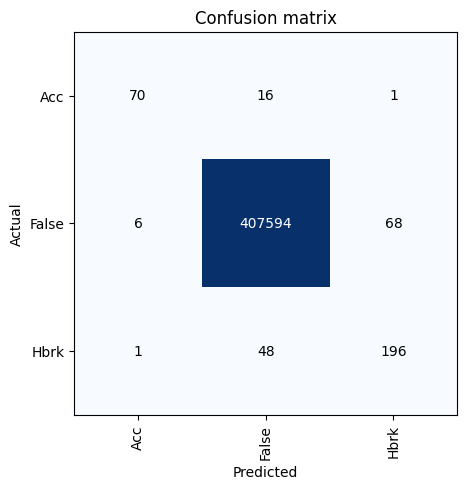

In [6]:
model_src = '/data/NIA50/docker/50-1/models/pth/8to11/speed'
test_src = '/data/NIA50/docker/50-1/data/8to11/test/dls8to11_test_speed.pkl'

learn = load_learner_all(dls_fname=f'{model_src}/dls', model_fname=f'{model_src}/model', learner_fname=f'{model_src}/learner')
dls8to11_test_speed = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8to11_test_speed, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8to11_test_speed).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas)

### # Hazard
---

accuracy : 0.9967 
precision : 0.4983 
recall : 0.5 
F1 score : 0.4992


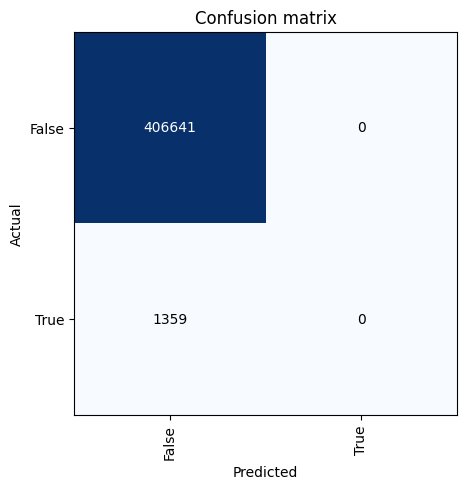

In [9]:
model_src = '/data/NIA50/docker/50-1/models/pth/8to11/hazard'
test_src = '/data/NIA50/docker/50-1/data/8to11/test/dls8to11_test_hazard.pkl'

learn = load_learner_all(dls_fname=f'{model_src}/dls', model_fname=f'{model_src}/model', learner_fname=f'{model_src}/learner')
dls8to11_test_hazard = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8to11_test_hazard, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8to11_test_hazard).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas[:, 1])

accuracy : 0.9967 
precision : 0.4983 
recall : 0.5 
F1 score : 0.4992


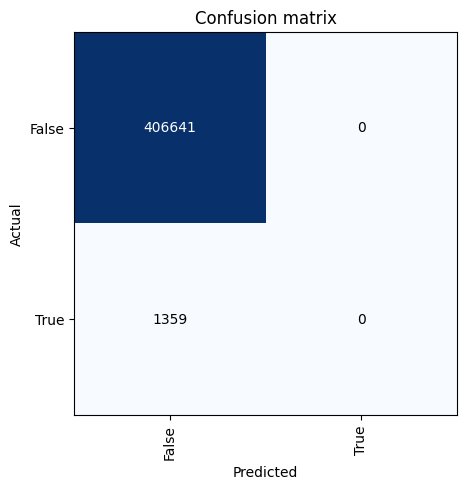

In [5]:
model_src = '/data/NIA50/docker/50-1/models/pth/8to11/hazard2'
test_src = '/data/NIA50/docker/50-1/data/8to11/test/dls8to11_test_hazard.pkl'

learn = load_learner_all(dls_fname=f'{model_src}/dls', model_fname=f'{model_src}/model', learner_fname=f'{model_src}/learner')
dls8to11_test_hazard = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8to11_test_hazard, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8to11_test_hazard).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas[:, 1])

accuracy : 0.9964 
precision : 0.5159 
recall : 0.5013 
F1 score : 0.5018


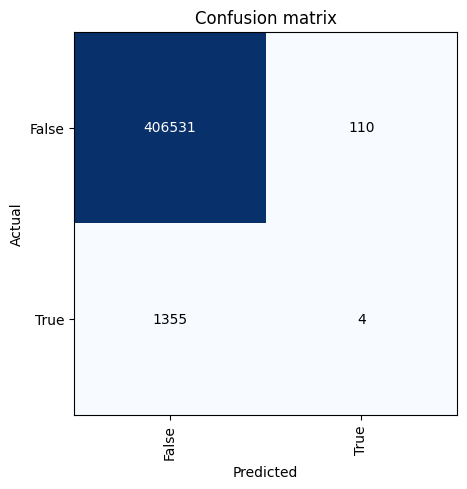

In [6]:
model_src = '/data/NIA50/docker/50-1/models/pth/8to11/hazard2'
test_src = '/data/NIA50/docker/50-1/data/8to11/test/dls8to11_test_hazard.pkl'

learn = load_learner_all(dls_fname=f'{model_src}/dls', model_fname=f'{model_src}/model', learner_fname=f'{model_src}/learner')
dls8to11_test_hazard = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8to11_test_hazard, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8to11_test_hazard).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas[:, 1])

## # 8월(세종)
---

### # Turn
---

accuracy : 0.954 
precision : 0.6954 
recall : 0.6247 
F1 score : 0.6356


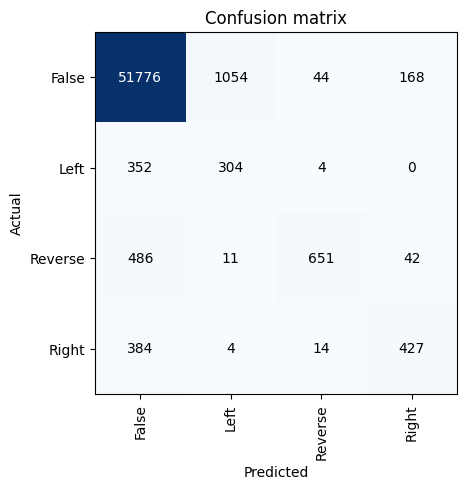

In [4]:
model_src = '/data/NIA50/docker/50-1/models/pth/8s/turn2'
test_src = '/data/NIA50/docker/50-1/data/8s/test/dls8s_test_turn.pkl'

learn = load_learner_all(dls_fname=f'{model_src}/dls', model_fname=f'{model_src}/model', learner_fname=f'{model_src}/learner')
dls8s_test_hazard = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8s_test_hazard, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8s_test_hazard).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas)

### # Speed
---

accuracy : 0.9968 
precision : 0.9968 
recall : 0.9968 
F1 score : 0.9968


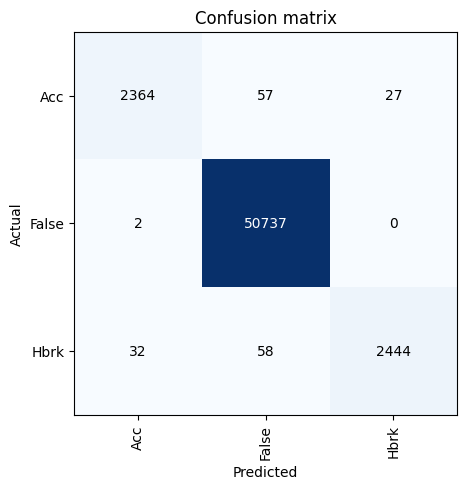

In [25]:
src = '/data/NIA50/docker/50-1/models/pth/8s/speed'
test_src = '/data/NIA50/docker/50-1/data/8s/test/dls8s_test_speed.pkl'

learn = load_learner(fname=f'{src}/learner.pkl')
dls8s_test_speed = torch.load(test_src)

test_probas, test_targets, test_preds = learn.get_preds(dl=dls8s_test_speed, with_decoded=True)

ClassificationInterpretation.from_learner(learn, dl=dls8s_test_speed).plot_confusion_matrix()
get_clf_eval(test_targets, test_preds, test_probas)